<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Un poco de series temporales<a id="top"></a>

<i>Última actualización: 2024-03-07</small></i></div>
***

## Introducción

Una serie temporal es una secuencia de observaciones obtenidas a intervalos regulares de tiempo (por ejemplo, décimas de segundo, días, años, etc.).

Tradicionalmente, el análisis de series temporales (que es basicamente comprender aspectos de la naturaleza inherente a la serie) es el paso previo a una predicción. Estas predicciones son de enorme importancia en muchos negocios diferentes, y si se puede encontrar una relación entre las variables de entrada con la predicción se puede ser extremadamente competitivo en el área.

## Objetivos

Este cuaderno pretende dar nociones de cómo trabajar con series temporales. Aunque es muy sencillo, al final habremos aprendido a:

- Cargar series temporales en dataframes y cómo operar y visualizar sus datos,
- Descomponer una serie temporal en sus supuestos componentes (o al menos a intentarlo), y
- Estimar lo predecible que puede ser una serie temporal utilizando el concepto de entropía.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Carga de las series temporales

Los conjuntos de datos de una serie temporal, como cualquier otro _dataset_, suelen almacenarse en bases de datos relacionales, bases de datos no relacionales, hojas de cálculo o, en archivos planos en formato tabular (por ejemplo, archivos `.csv`). Incluyen al menos las columnas correspondientes a la hora y el valor medido para esa hora.

Utilizaremos la función `read_csv` de pandas para cargar una serie temporal ya descargada para este cuaderno, concretamente la acción GameStop obtenida del [historical data stored by Nasdaq](https://www.nasdaq.com/es/market-activity/stocks/gme). El conjunto de datos se encuentra en la ruta relativa `datasets/GME-full-historical-data-20211001.csv`. Lo cargaremos con la columna `Date` como índice de tipo `Date`.

In [ ]:
df = pd.read_csv('datasets/GME-20211001.csv', index_col='Fecha', parse_dates=['Fecha'])
df.head()

,Cerrar/último,Volumen,Abrir,Alto,Bajo
Fecha,,,,,
2021-10-01,$176.91,1551139,$179.4,$179.49,$172.25
2021-09-30,$175.47,3177453,$175,$185.4499,$166.79
2021-09-29,$175.92,1899933,$180.09,$184.48,$174.61
2021-09-28,$178.6,1770493,$188,$190.8099,$178
2021-09-27,$189.48,1470146,$185.92,$192.05,$185.87


En realidad, el conjunto de datos cargado como tal no se denomina serie temporal. Su término correcto es **datos de panel** (_panel data_) y se refiere a un conjunto de datos relacionados que pertenecen a la misma dimensión temporal. En otras palabras, varias series temporales con el mismo eje temporal de datos relacionados es un panel de datos.

Vamos a centrarnos en las series temporales relacionadas con la columna `Cerrar/último`, que vienen a ser los valores de cierre de las acciones. En concreto

1. Vamos a crear una columna llamada `valor` con los datos de cierre en como tipo de dato `float`.
2. Vamos a descartar el resto de columnas porque nos vamos a centrar en esa serie temporal en concreto.

In [4]:
df['value'] = df['Cerrar/último'].replace('[\$]', '', regex=True)
df['value'] = df['value'].astype('float')
values = df[['value']]
values.head()

,value
Fecha,
2021-10-01,176.91
2021-09-30,175.47
2021-09-29,175.92
2021-09-28,178.60
2021-09-27,189.48


## Visualizando series temporales

Ahora vamos a visualizar la serie temporal, donde el eje $X$ será la dimensión temporal (es decir, los días) y el eje $Y$ el valor de la acción en ese día concreto.

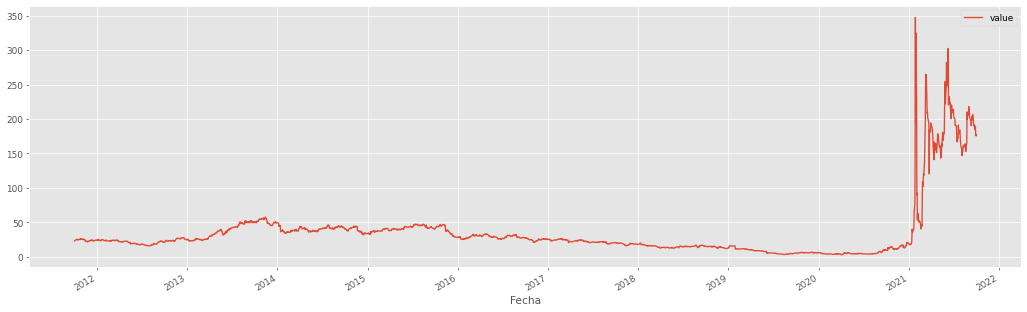

In [5]:
values.plot.line();

En realidad, las acciones de GameStop en 2021 sufrieron un repentino crecimiento debido a razones que, si no conoces, te recomiendo buscar información al respecto porque es bastante divertido.

Como es una serie un poco grande, vamos a convertir la serie temporal en el rango de los años 2015 a 2016 (ambos incluidos) y visualizarla.

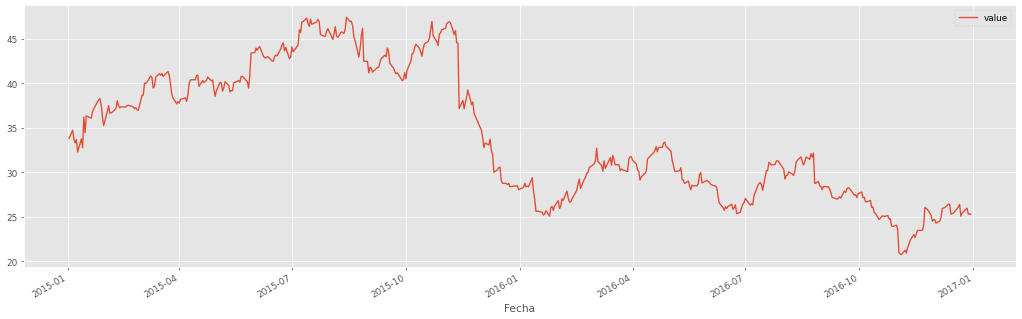

In [6]:
values = values.sort_index().loc['2015/01/01':'2017/01/01']
values.plot.line(y='value');

## Descomponiendo la serie temporal

Podemos realizar una descomposición clásica de una serie temporal utilizando la función `seasonal_decompose` de la librería `statsmodel`. Lo que hace esto es considerar nuestra serie como una combinación (aditiva o multiplicativa). Una descomposición clásica de una serie temporal puede hacerse considerando la serie como una combinación aditiva o multiplicativa del nivel base, la tendencia, el índice estacional y el residuo.

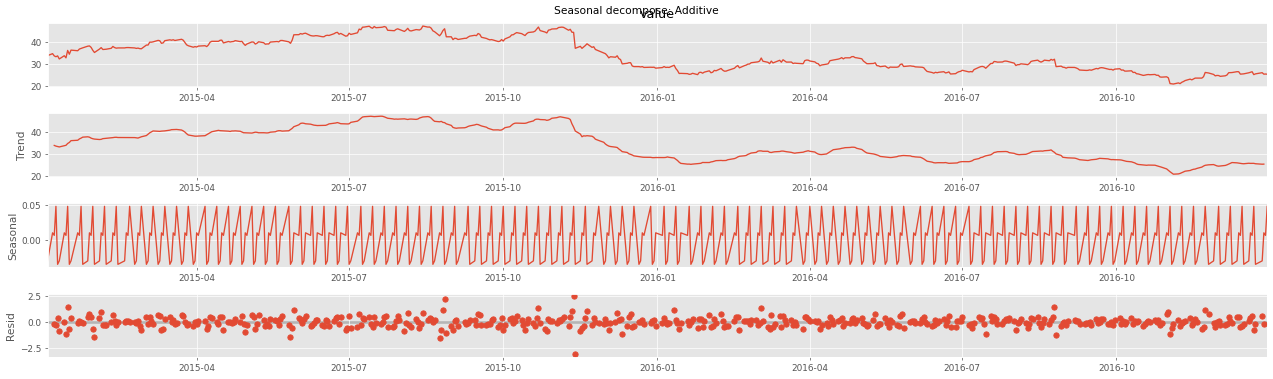

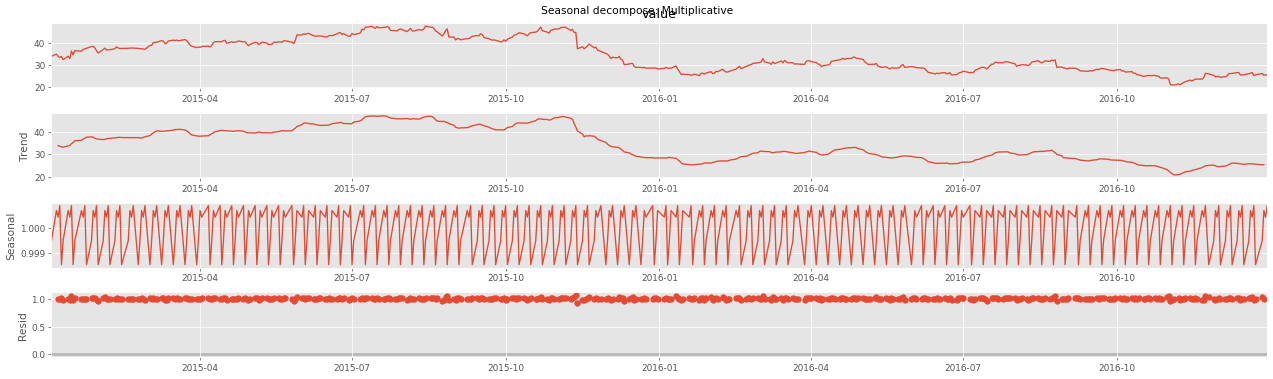

In [7]:
dec_add = seasonal_decompose(values['value'], period=5, model='additive')
dec_add.plot().suptitle('Seasonal decompose: Additive')

dec_mul = seasonal_decompose(values['value'], period=5, model='multiplicative')
dec_mul.plot().suptitle('Seasonal decompose: Multiplicative');

En nuestro caso no falta ningún valor entre días, pero si así fuera, se podría especificar el parámetro `extrapolate_trend='freq'` para extrapolar los valores que faltan.

Podemos acceder al dataframe de las series componentes a partir de concatenar las series concretas de la descomposición:

In [8]:
df_components = pd.concat([dec_add.seasonal, dec_add.trend, dec_add.resid, dec_add.observed], axis=1)
df_components.columns = ['seasonal', 'trend', 'residual', 'values']
df_components.iloc[20:25]

,seasonal,trend,residual,values
Fecha,,,,
2015-02-02,-0.030276,36.496,0.364276,36.83
2015-02-03,0.010304,36.582,0.907696,37.50
2015-02-04,0.006624,36.884,-0.260624,36.63
2015-02-05,0.048624,36.954,-0.302624,36.70
2015-02-06,-0.035276,37.062,-0.266724,36.76


Debería cumplirse que `values = seasonal + trend + residual` para cada fila (excepto para algunas primeras y últimas mediciones). En este ejemplo concreto, la serie es algo aleatoria. Si probamos con otras series como, por ejemplo, las ventas en una tienda online, obtendríamos una descomposición más «típica».

## Estimación de la «previsibilidad» de una serie temporal

Cuanto más regulares sean los patrones de una serie temporal, más fácil será predecir sus valores futuros. Dos valores que podemos calcular para intentar estimar lo regulares o impredecibles que son las fluctuaciones de la serie son las entropías _aproximada_ y _muestral_:

* **[Entropía aproximada](https://en.wikipedia.org/wiki/Approximate_entropy)**: Nos da un valor de la variabilidad de los valores de una serie. Cuanto mayor sea la entropía aproximada, más aleatorias serán las fluctuaciones de la serie y, por tanto, menos predecibles.
* **[Entropía muestral](https://en.wikipedia.org/wiki/Sample_entropy)**: Similar a la entropía aproximada pero más consistente (menos sensible al tamaño de la serie) en el cálculo.

Estos valores dan una intuición de la fluctuación del valor. Por ejemplo, supongamos que tenemos las siguientes dos secuencias de bits:

1. `01010101`
2. `00101101`

Tanto con medidas de tendencia central como de dispersión (por ejemplo, media, mediana, desviación típica), ambas secuencias arrojan los mismos resultados; además, ambas secuencias dan el mismo valor de entropía, por lo que la información que puedo obtener de ambas es prácticamente la misma. Sin embargo, la primera serie es claramente regular, mientras que la segunda parece más aleatoria. Las entropías aproximada y muestral aprovechan este comportamiento para dar un valor más bajo cuanto más regular es la secuencia.

Desgraciadamente, no es una medida que nos aporte demasiada información salvo cuando la comparamos con otras series (esta serie es más _predecible_ que ésta). Sin embargo, en este comportamiento es una herramienta que puede ser bastante útil.

Implementemos la función de entropía muestral

In [9]:
def sample_entropy(L, m, r):
    # Source: https://en.wikipedia.org/wiki/Sample_entropy
    N = len(L)
    B = 0.0
    A = 0.0
    
    
    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

    # Return SampEn
    return -np.log(A / B)

El valor de la entropía pertenece al intervalo $(0, \infty)$, y empíricamente se considera que valores superiores a 0,25 son sinónimo de baja "predictibilidad". Veamos cuál es la entropía de mustra de nuestra serie.

In [10]:
entropy = sample_entropy(L=values.value, m=2, r=0.2*np.std(values.value))
print(f'Sample entropy: {entropy}')

Sample entropy: 0.24095408131421822


Un valor ligeramente bajo, por lo que parece que esta serie puede ser ligeramente predecible.

## Conclusiones

No vamos a profundizar más. Este cuaderno es más para entrar en series, trabajar un poco con pandas e identificar una forma de comparar la complejidad de dos series para entender si lo que vamos a predecir es realmente predecible.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Back to top](#top)

</div>